In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Tuple, List
from pydantic import BaseModel, Field
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load results

In [2]:
# pydantic model

class PreprocessingSteps(BaseModel):
    transformers: Tuple[
        Tuple[PCA, StandardScaler, np.ndarray, np.ndarray],
        Tuple[float, float]
    ] = Field(
        ..., 
        description="Preprocessing steps including PCA, StandardScaler, and arrays"
    )

    class Config:
        arbitrary_types_allowed = True
        json_encoders = {
            np.ndarray: lambda v: v.tolist(),
            PCA: lambda v: str(v),
            StandardScaler: lambda v: str(v)
        }


In [11]:
def load_data(dataset: str, activation: str = "relu") -> dict:
    """
    Load data from pickle files for a specific dataset.
    
    Args:
        dataset (str): Name of the dataset or specific subdirectory
    
    Returns:
        dict: A dictionary with full file paths as keys and loaded data as values
    """
    
    base_dir = "../results/datasets/real_world_data/"
    if dataset in ["circles", "spheres", "alternate_stripes"]:
        base_dir = "../results/datasets/synthetic_data"
    
    full_path = os.path.join(base_dir, dataset)
    full_path = full_path + f"/activation={activation}"

    print(full_path)
    
    data_dict = {}
    
    # Walk through the directory tree starting from the specified dataset path
    for root, dirs, files in os.walk(full_path):
        for file in files:
            # Check if the file is a pickle file
            if file.endswith('.pkl') or file.endswith('.p'):
                full_file_path = os.path.join(root, file)
                
                try:
                    # Load the pickle file
                    with open(full_file_path, "rb") as f:
                        data = pickle.load(f)
                    
                    # Store in the dictionary with full path as key
                    data_dict[full_file_path] = data
                
                except (IOError, pickle.UnpicklingError) as e:
                    print(f"Error loading {full_file_path}: {e}")
    
    return data_dict

In [30]:
def read_all_nested_files(dataset: str, activation: str = "relu"):

    base_dir = "../results/datasets/real_world_data/"
    if dataset in ["circles", "spheres", "alternate_stripes"]:
        base_dir = "../results/datasets/synthetic_data"
    
    full_path = os.path.join(base_dir, dataset)
    full_path = full_path + f"/activation={activation}"
    
    # Dictionary to store file contents with file paths as keys
    file_contents = {}
    
    # Walk through all directories and files
    for root, dirs, files in os.walk(full_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            if "results_list.p" in file_path:
                print(file_path)
                try:
                    content = pickle.load(open(file_path, 'rb'))
                    # Store content with full path as key
                    file_contents[file_path] = content
                except Exception as e:
                    print(f"Could not read {file_path}: {e}")
    
    return file_contents

# functions to collate the data

In [8]:
# get the explained variance objectives for train and validation

def extract_explained_variance(data: list[list[PreprocessingSteps]]) -> np.array:

    explained_variance = []
    
    for j in range(len(data)):
        
        data_run = [data[j][i][-1] for i in range(len(data[j]))]
        explained_variance.append(data_run)
  
    return np.array(explained_variance)

# visualise

In [9]:
def plot_percentiles(partial_data, full_data, dataset: str):
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Colors for different contribution types
    colors = {'partial': 'darkred', 'full': 'darkblue'}
    labels = ['training', 'validation']
    linestyles = ['--', '-']

    activation_fn = 'relu'
    if dataset == 'alternate_stripes':
        activation_fn = 'cos'

    legend_list = [f"h={activation_fn}, objective=partial",
                   f"h={activation_fn}, objective=partial",
                   f"h={activation_fn}, objective=full",
                   f"h={activation_fn}, objective=full"]
    legend_entries = []
    
    # Plot both partial and full contributions
    enumerate_counter = 0
    for data, contrib_type in [(partial_data, 'partial'), (full_data, 'full')]:
        # Compute percentiles along the first axis (runs)
        p20 = np.percentile(data, 20, axis=0)
        p50 = np.percentile(data, 50, axis=0)
        p80 = np.percentile(data, 80, axis=0)
        
        # Create x-axis (time steps)
        x = np.arange(data.shape[1])
        
        # Plot for each dimension (training/validation)
        for dim in range(2):
            plt.plot(x, p50[:, dim], color=colors[contrib_type], 
                    label=f'{contrib_type.capitalize()} {labels[dim]} Median', 
                    linestyle=linestyles[dim], linewidth=1.0)
            if dim == 0:
                legend_entries.append(legend_list[enumerate_counter])
            else:
                legend_entries.append(f"_")

            plt.fill_between(x, p20[:, dim], p80[:, dim], 
                           alpha=0.2, color=colors[contrib_type])
            legend_entries.append(f"_")

            enumerate_counter += 1
    
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend(loc='upper left', labels=legend_entries)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # path_to_save = f"../results/plots/training_curve/{dataset}.pdf"
    # directory = os.path.dirname(path_to_save)
    # if not os.path.exists(directory):
    #     os.makedirs(directory)
        
    # plt.savefig(path_to_save, dpi=300)
    # plt.close()

../results/datasets/real_world_data/german_credit/activation=relu/partial_contrib=false/12/results_list.p
../results/datasets/real_world_data/german_credit/activation=relu/partial_contrib=false/9/results_list.p
../results/datasets/real_world_data/german_credit/activation=relu/partial_contrib=false/11/results_list.p
../results/datasets/real_world_data/german_credit/activation=relu/partial_contrib=false/6/results_list.p
../results/datasets/real_world_data/german_credit/activation=relu/partial_contrib=false/8/results_list.p
../results/datasets/real_world_data/german_credit/activation=relu/partial_contrib=false/2/results_list.p
../results/datasets/real_world_data/german_credit/activation=relu/partial_contrib=false/7/results_list.p
../results/datasets/real_world_data/german_credit/activation=relu/partial_contrib=false/3/results_list.p
../results/datasets/real_world_data/german_credit/activation=relu/partial_contrib=false/4/results_list.p
../results/datasets/real_world_data/german_credit/act

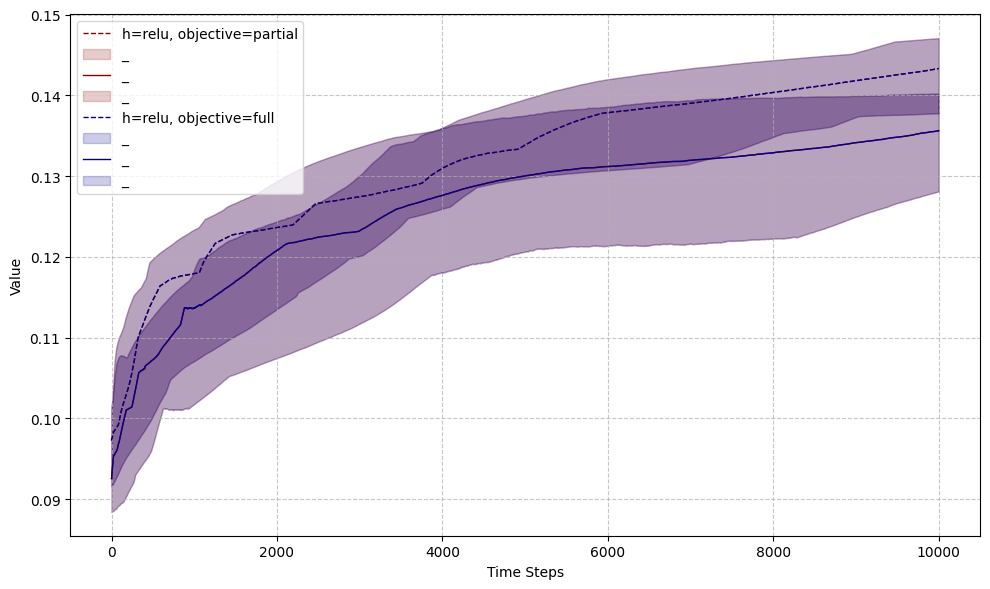

In [31]:
# Modified main loop
# dataset_list = ["alternate_stripes", "circles", "spheres", "wine", "heart-statlog", "ionosphere", "breast-cancer"]
dataset_list = ["german_credit"]
for dataset in dataset_list:
    activation = "relu"
    data_dictionary = read_all_nested_files(dataset)
    if dataset == "alternate_stripes":
        activation = "cos"
    
    partial_contrib_data = [value for key, value in data_dictionary.items() 
                          if 'partial_contrib=true' in key and activation in key]
    full_contrib_data = [value for key, value in data_dictionary.items() 
                        if 'partial_contrib=false' in key and activation in key]
    
    explained_variance_partial = extract_explained_variance(partial_contrib_data)
    explained_variance_full = extract_explained_variance(full_contrib_data)
    
    # Plot both contributions on the same figure
    plot_percentiles(explained_variance_partial, explained_variance_full, dataset)